# prototyping LSS pipeline

## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/alf/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/alf/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
import sys
sys.path.append('/home/alf/Desktop/LSS/FergLabLSS/LSS_components')
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [6]:
# DESRES Chignolin at 340 K
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/home/alf/Desktop/LSS/Chignolin/DESRES-Trajectory_CLN025-0-protein/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/home/alf/Desktop/LSS/Chignolin/DESRES-Trajectory_CLN025-0-protein/CLN025-0-protein/"
trj_file = []
for i in np.arange(0,10):
    fname = "CLN025-0-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))

In [7]:
view = nv.show_structure_file(pdb_file)
#view.clear_representations()
#view.add_ball_and_stick()
view

NGLWidget()

### mdtraj load and view

In [8]:
traj_obj = md.load(trj_file, top=pdb_file)

In [9]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

<mdtraj.Trajectory with 100000 frames, 166 atoms, 10 residues, and unitcells at 0x7f63aa4785f8>

In [10]:
view = nv.show_mdtraj(traj_obj)
#view.clear_representations()
#view.add_spacefill()
view

NGLWidget(count=100000)

#### h2t

In [11]:
Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

In [12]:
h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

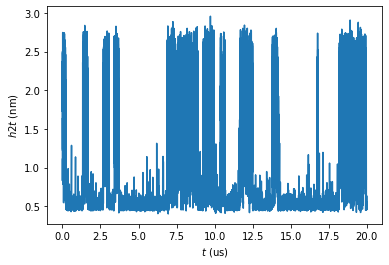

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, h2t)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

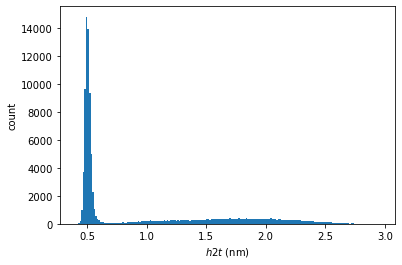

In [14]:
fig, ax = plt.subplots()
_ = plt.hist(h2t, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$h2t$ (nm)")
plt.show()

#### RMSD

In [15]:
view = nv.show_mdtraj(traj_obj[25000])
#view.clear_representations()
#view.add_spacefill()
view

NGLWidget()

In [16]:
rmsd = md.rmsd(traj_obj,traj_obj[25000],0)

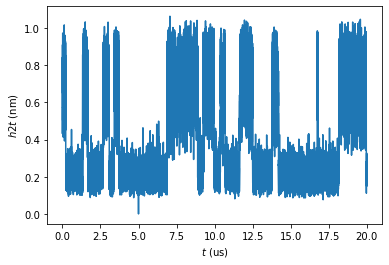

In [17]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, rmsd)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

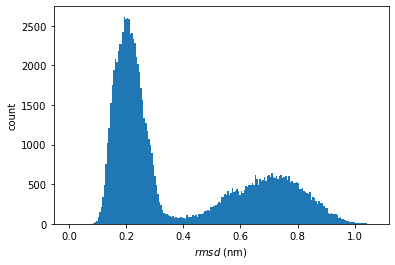

In [18]:
fig, ax = plt.subplots()
_ = plt.hist(rmsd, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$rmsd$ (nm)")
plt.show()

#### dihedrals

## featurization

In [19]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

04-12-20 19:20:46 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 505


In [20]:
data = np.zeros((0,features.dimension()))
for i in range(len(trj_file)):
    q = py.coordinates.load(trj_file[i], features=features)
    data = np.concatenate((data,q), axis=0)
    print(i)
    print(data.shape)

0
(10000, 505)
1
(20000, 505)
2
(30000, 505)
3
(40000, 505)
4
(50000, 505)
5
(60000, 505)
6
(70000, 505)
7
(80000, 505)
8
(90000, 505)
9
(100000, 505)


## (1) latent space projection

### parameters

In [21]:
lag=50
dim=5
is_reversible=True

### SRV

In [22]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [23]:
hde.fit(data)


Instructions for updating:
Use `tf.cast` instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300




99950/99950 [==============================] - 2s 17us/step - loss: -1.7628
Epoch 2/300
99950/99950 [==============================] - 1s 6us/step - loss: -1.9438
Epoch 3/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.0044
Epoch 4/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.0577
Epoch 5/300
99950/99950 [==============================] - 1s 5us/step - loss: -2.0946
Epoch 6/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.1239
Epoch 7/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.1510
Epoch 8/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.1771
Epoch 9/300
99950/99950 [==============================] - 1s 6us/step - loss: -2.2067
Epoch 10/300
99950/99950 [==============================] - 1s

99950/99950 [==============================] - 1s 6us/step - loss: -4.1092
Epoch 157/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1157
Epoch 158/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1017
Epoch 159/300
99950/99950 [==============================] - 1s 6us/step - loss: -4.1196
Epoch 160/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1125
Epoch 161/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1292
Epoch 162/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1260
Epoch 163/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1454
Epoch 164/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1497
Epoch 165/300
99950/99950 [==============================] - 1s 6us/step - loss: -4.1573
Epoch 166/300
99950/99950 [==============================] - 1s 5us/step - loss: -4.1705
Epoch 167/300
99950/99950 [========

HDE(activation=None, batch_normalization=True, batch_size=20000, callbacks=None,
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=505,
    l2_regularization=0.0, lag_time=50, latent_space_noise=0,
    learning_rate=0.0005, n_components=5, n_epochs=300, reversible=True,
    validation_split=0, verbose=True)

In [24]:
#hde.callbacks = None
#hde.history = None
pickle.dump(hde, open('hde.pkl', 'wb'), protocol=4)

In [25]:
hde = pickle.load(open('hde.pkl', 'rb'))

In [26]:
hde_coords = hde.transform(data, side='left')
#hde_coords_right = hde.transform(data, side='right')
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
#print(hde_coords_right)

[2268.9051915   764.61775703  263.63034699  244.99891283   64.06039686]
[[-1.2810299  -0.1013303  -0.01922089  0.13667582  0.02808764]
 [-1.2161701  -0.13399701  0.14267746 -0.34220743 -0.18273288]
 [-1.2630038  -0.03809679  0.08637345 -0.06988692  0.00241419]
 ...
 [ 0.8126483  -0.04551812 -0.05347946 -0.01294567 -2.371208  ]
 [ 0.80621254 -0.01203691  0.01001072  0.07990278 -2.3773952 ]
 [ 0.8012541  -0.01323701 -0.07977678  0.0317432  -2.2930162 ]]


<function matplotlib.pyplot.show(*args, **kw)>

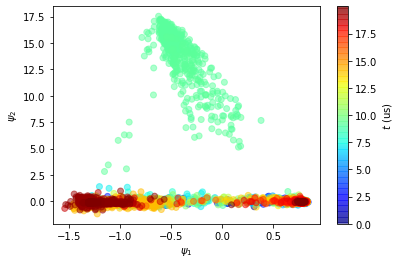

In [27]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(hde_coords[:,0],hde_coords[:,1], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$\psi_2$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

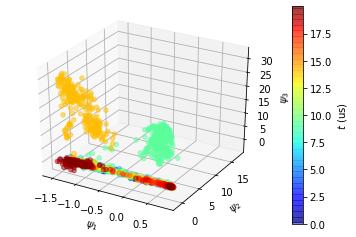

In [28]:
# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(hde_coords[:, 0], hde_coords[:, 1], hde_coords[:, 2], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

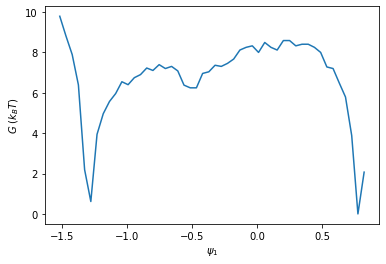

In [29]:
# 1D PMF
pdf, bin_edges = np.histogram(hde_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

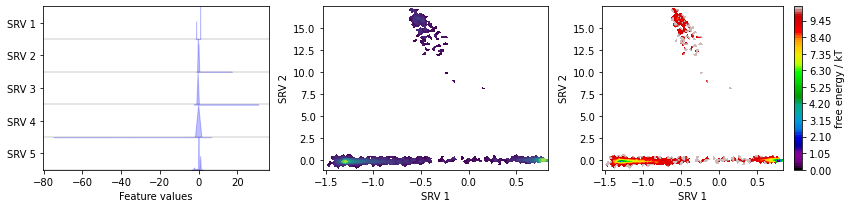

In [30]:
# pyemma distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    hde_coords, ['SRV {}'.format(i + 1) for i in range(dim)], ax=axes[0])
py.plots.plot_density(*hde_coords[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*hde_coords[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('SRV 1')
    ax.set_ylabel('SRV 2')
fig.tight_layout()

In [31]:
def plot_its(lags, its, its_stderr, dim, data_name, ax, marker='o'):

    colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']

    for i in range(dim):
        ax.plot(lags,its[:,i].flatten(), marker=marker, color=colors[i], label=data_name + ' $t$' + str(i))
        ax.fill_between(lags, its[:,i].flatten() - its_stderr[:,i].flatten(), its[:,i].flatten() + its_stderr[:,i].flatten(), alpha=0.2, color=colors[i])
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.set_ylim(ymin = np.min(lags))
    ax.set_yscale('log')
    ax.legend(loc='lower right')

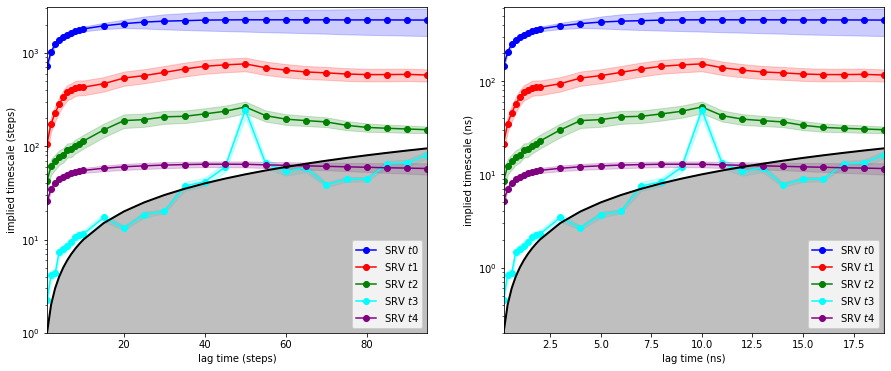

In [32]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(hde_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(hde_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_SRV = copy.deepcopy(its)
its_SRV_stderr = copy.deepcopy(its_stderr)

### tICA

In [33]:
tica = py.coordinates.tica(data, dim=dim, lag=lag)
tica_coords = tica.get_output()[0]
print(tica.timescales[:dim])
print(tica_coords)

[1874.58009904  119.08092225   74.35178411   63.14387158   53.00460443]
[[-1.1083225  -0.5886358  -0.01851608 -1.1093659   0.39830962]
 [-0.9851006  -0.4758668  -0.13819006  0.31048867  0.49034664]
 [-1.0000664  -0.5290365   0.21605505  0.00640881 -0.01059022]
 ...
 [ 0.749035   -0.02673689  0.17636909 -0.04247835  0.74966174]
 [ 0.67786485 -0.10808726  0.09388544  0.01447634  0.7693855 ]
 [ 0.7744183  -0.10282312 -0.08429761 -0.07553143  0.82981825]]


<function matplotlib.pyplot.show(*args, **kw)>

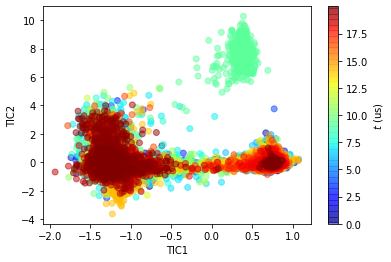

In [34]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(tica_coords[:,0], tica_coords[:,1], c=np.arange(tica_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

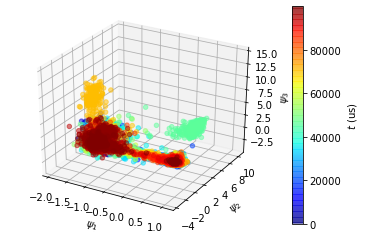

In [35]:
# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(tica_coords[:, 0], tica_coords[:, 1], tica_coords[:, 2], c=np.arange(tica_coords.shape[0]), alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

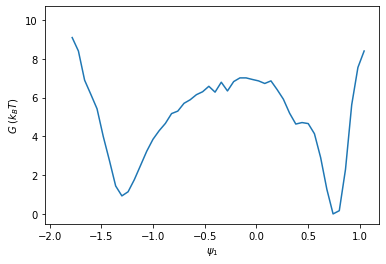

In [36]:
# 1D PMF
pdf, bin_edges = np.histogram(tica_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

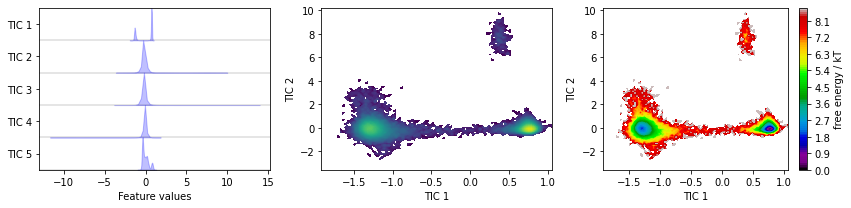

In [37]:
# pyemma distributions
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    tica_concatenated, ['TIC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
fig.tight_layout()

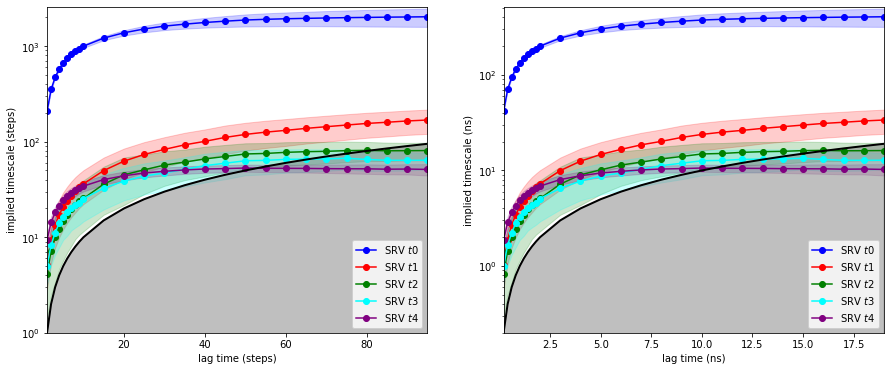

In [38]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(tica_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(tica_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_TICA = copy.deepcopy(its)
its_TICA_stderr = copy.deepcopy(its_stderr)

### SRVs vs. tICA implied time scales

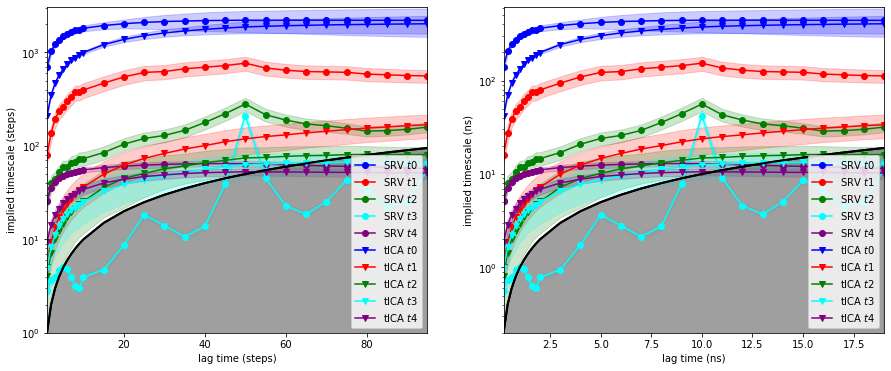

In [39]:
# implied time scales: SRVs vs. tICA

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its_SRV, its_SRV_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')
plot_its(lags, its_TICA, its_TICA_stderr, dim, 'tICA', ax[0], marker='v')

plot_its(lags*timestep/1E3, its_SRV*timestep/1E3, its_SRV_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')
plot_its(lags*timestep/1E3, its_TICA*timestep/1E3, its_TICA_stderr*timestep/1E3, dim, 'tICA', ax[1], marker='v')

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

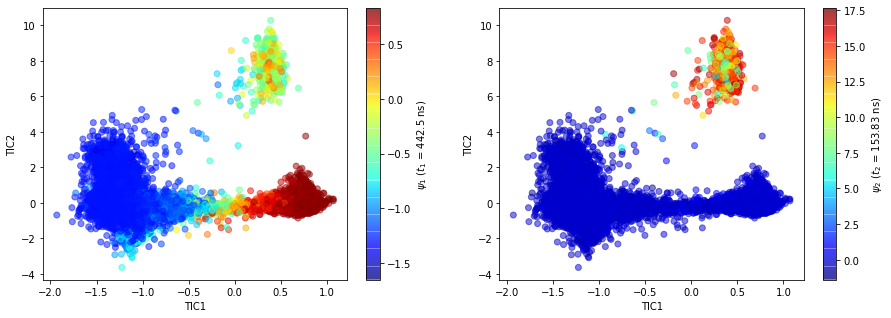

In [40]:
# 2D scatterplot
fig, ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,0], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label(r'$\psi_1$ ($t_1$ = ' + str(np.round(hde_timescales[0]*timestep/1E3,2)) + ' ns)')
ax[0].set_xlabel('TIC1')
ax[0].set_ylabel('TIC2')

im = ax[1].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,1], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'$\psi_2$ ($t_2$ = ' + str(np.round(hde_timescales[1]*timestep/1E3,2)) + ' ns)')
ax[1].set_xlabel('TIC1')
ax[1].set_ylabel('TIC2')

plt.show

### kernel TICA

### SRV k-means clustering

#### n_cluster optimization using silhouette score

- expect n_cluster = (dim_kmeans+1) similar to PCCA (# macrostates = 1 + # singular vectors)

- Idea of inner simplex (PCCA) clustering directly in singular vectors of transfer operator:
F. Paul, H. Wu, M. Vossel, B.L. de Groot, and F. Noe "Identification of kinetic order parameters
for non-equilibrium dynamics" J. Chem. Phys. 150, 164120 (2019); doi: 10.1063/1.5083627

- k-means simpler and only for understanding of macrostates not construction of MSM

In [41]:
dim_kmeans = 2
hde_coords_kmeans = copy.deepcopy(hde_coords[:,:dim_kmeans])

In [42]:
range_n_clusters = np.arange(2,5,1)
silhouette_avg_array = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=200184)
    cluster_labels = clusterer.fit_predict(hde_coords_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(hde_coords_kmeans, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_array.append(silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.9402504
For n_clusters = 3 The average silhouette_score is : 0.97631055
For n_clusters = 4 The average silhouette_score is : 0.97652906


In [43]:
n_clusters = dim_kmeans+1 # usually, but check silhouette scores

In [44]:
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(hde_coords_kmeans)
centers = clusterer.cluster_centers_
sample_silhouette_values = silhouette_samples(hde_coords_kmeans, cluster_labels)

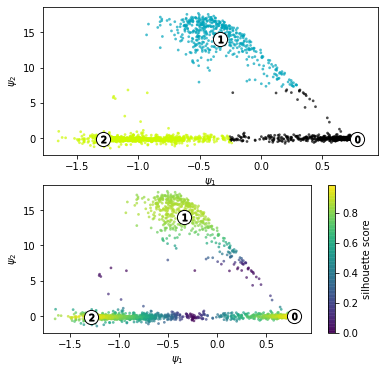

In [45]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im1 = ax1.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_xlabel("$\psi_1$")
ax1.set_ylabel("$\psi_2$")

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im2 = ax2.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=sample_silhouette_values, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_xlabel("$\psi_1$")
ax2.set_ylabel("$\psi_2$")
cbar = fig.colorbar(im2, ax=ax2)
cbar.set_label('silhouette score')

plt.show()

#### visualizing configs proximate to k-means centers

In [46]:
centers

array([[ 0.779474  , -0.04847411],
       [-0.3371344 , 14.029939  ],
       [-1.2859768 , -0.10141591]], dtype=float32)

In [47]:
kmeans_viz = []
for i in range(n_clusters):
    idx_sort = np.argsort(np.sqrt(np.sum((hde_coords_kmeans - centers[i,:])**2, axis=1)))
    kmeans_viz.append(idx_sort[:10])

In [48]:
for i in range(n_clusters):
    print(hde_coords_kmeans[kmeans_viz[i][0],:])

[ 0.7794112  -0.04850614]
[-0.3228236 14.070731 ]
[-1.2855289  -0.10137283]


In [49]:
clust_id = 0
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

In [50]:
clust_id = 1
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

In [51]:
clust_id = 2
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

NGLWidget()

In [52]:
view = nv.NGLWidget()
view.add_trajectory(traj_obj[kmeans_viz[0][0]])
view.component_0.clear_representations()
view.component_0.add_cartoon(color='blue', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[1][0]])
view.component_1.clear_representations()
view.component_1.add_cartoon(color='red', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[2][0]])
view.component_2.clear_representations()
view.component_2.add_cartoon(color='green', opacity=0.8)
view

NGLWidget()

## (2) propagator

In [53]:
dim_prop = 2

In [54]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [55]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [56]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [57]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [58]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.



In [59]:
from hde.propagator import get_mixture_loss_func

In [60]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [61]:
if is_reversible:
    prop.fit([traj_prop_scaled, traj_prop_scaled[::-1]]) # reversible -- data augmentation with inverted trajectory
else:
    prop.fit(traj_prop_scaled)

Train on 199900 samples
Epoch 1/20000
199900/199900 [==============================] - 1s 4us/sample - loss: 2.0364
Epoch 2/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0347
Epoch 3/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0331
Epoch 4/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0314
Epoch 5/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0297
Epoch 6/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0280
Epoch 7/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0263
Epoch 8/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0247
Epoch 9/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0230
Epoch 10/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 2.0213
Epoch 11/20000
199900/199900 [=========================

Epoch 89/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8561
Epoch 90/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8531
Epoch 91/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8501
Epoch 92/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8471
Epoch 93/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8440
Epoch 94/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8409
Epoch 95/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8377
Epoch 96/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8345
Epoch 97/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8313
Epoch 98/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.8281
Epoch 99/20000
199900/199900 [==============================] - 0s 2us

Epoch 177/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3971
Epoch 178/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3890
Epoch 179/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3808
Epoch 180/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3725
Epoch 181/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3641
Epoch 182/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3556
Epoch 183/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3471
Epoch 184/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3384
Epoch 185/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3296
Epoch 186/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 1.3208
Epoch 187/20000
199900/199900 [=============================

199900/199900 [==============================] - 0s 2us/sample - loss: 0.1068
Epoch 265/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 0.0802
Epoch 266/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 0.0531
Epoch 267/20000
199900/199900 [==============================] - 0s 2us/sample - loss: 0.0257
Epoch 268/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.0022
Epoch 269/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.0304
Epoch 270/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.0591
Epoch 271/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.0881
Epoch 272/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.1176
Epoch 273/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -0.1474
Epoch 274/20000
199900/199900 [==============================] - 0s 2u

Epoch 351/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -2.9421
Epoch 352/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -2.9858
Epoch 353/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.0298
Epoch 354/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.0741
Epoch 355/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.1187
Epoch 356/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.1632
Epoch 357/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.2077
Epoch 358/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.2519
Epoch 359/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.2958
Epoch 360/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -3.3393
Epoch 361/20000
199900/199900 [===================

Epoch 438/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.1768
Epoch 439/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.1843
Epoch 440/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.1908
Epoch 441/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.1957
Epoch 442/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2011
Epoch 443/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2078
Epoch 444/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2144
Epoch 445/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2199
Epoch 446/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2251
Epoch 447/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.2313
Epoch 448/20000
199900/199900 [===================

Epoch 525/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.8999
Epoch 526/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9123
Epoch 527/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9232
Epoch 528/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9356
Epoch 529/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9492
Epoch 530/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9614
Epoch 531/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9730
Epoch 532/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9859
Epoch 533/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -5.9992
Epoch 534/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -6.0114
Epoch 535/20000
199900/199900 [===================

Epoch 612/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0006
Epoch 613/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0129
Epoch 614/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0246
Epoch 615/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0359
Epoch 616/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0472
Epoch 617/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0589
Epoch 618/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0710
Epoch 619/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0828
Epoch 620/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.0942
Epoch 621/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.1055
Epoch 622/20000
199900/199900 [===================

Epoch 699/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9183
Epoch 700/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9275
Epoch 701/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9366
Epoch 702/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9458
Epoch 703/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9548
Epoch 704/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9639
Epoch 705/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9729
Epoch 706/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9819
Epoch 707/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9907
Epoch 708/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -7.9994
Epoch 709/20000
199900/199900 [===================

Epoch 786/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4711
Epoch 787/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4739
Epoch 788/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4783
Epoch 789/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4813
Epoch 790/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4836
Epoch 791/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4874
Epoch 792/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4901
Epoch 793/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4928
Epoch 794/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.4969
Epoch 795/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.5004
Epoch 796/20000
199900/199900 [===================

Epoch 873/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6190
Epoch 874/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6197
Epoch 875/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6204
Epoch 876/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6212
Epoch 877/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6221
Epoch 878/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6228
Epoch 879/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6234
Epoch 880/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6240
Epoch 881/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6247
Epoch 882/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6252
Epoch 883/20000
199900/199900 [===================

Epoch 960/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6683
Epoch 961/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6697
Epoch 962/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6707
Epoch 963/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6709
Epoch 964/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6707
Epoch 965/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6709
Epoch 966/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6716
Epoch 967/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6724
Epoch 968/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6731
Epoch 969/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.6737
Epoch 970/20000
199900/199900 [===================

Epoch 1046/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7044
Epoch 1047/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7047
Epoch 1048/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7049
Epoch 1049/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7051
Epoch 1050/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7053
Epoch 1051/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7055
Epoch 1052/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7055
Epoch 1053/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7054
Epoch 1054/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7051
Epoch 1055/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7044
Epoch 1056/20000
199900/199900 [========

Epoch 1132/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7340
Epoch 1133/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7335
Epoch 1134/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7329
Epoch 1135/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7316
Epoch 1136/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7310
Epoch 1137/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7308
Epoch 1138/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7331
Epoch 1139/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7354
Epoch 1140/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7374
Epoch 1141/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7382
Epoch 1142/20000
199900/199900 [========

Epoch 1218/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7641
Epoch 1219/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7644
Epoch 1220/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7646
Epoch 1221/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7648
Epoch 1222/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7647
Epoch 1223/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7644
Epoch 1224/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7636
Epoch 1225/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7629
Epoch 1226/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7621
Epoch 1227/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7628
Epoch 1228/20000
199900/199900 [========

Epoch 1304/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7944
Epoch 1305/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7948
Epoch 1306/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7952
Epoch 1307/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7955
Epoch 1308/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7957
Epoch 1309/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7961
Epoch 1310/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7964
Epoch 1311/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7967
Epoch 1312/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7969
Epoch 1313/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.7970
Epoch 1314/20000
199900/199900 [========

Epoch 1390/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8257
Epoch 1391/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8260
Epoch 1392/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8264
Epoch 1393/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8268
Epoch 1394/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8272
Epoch 1395/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8277
Epoch 1396/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8280
Epoch 1397/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8284
Epoch 1398/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8288
Epoch 1399/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8292
Epoch 1400/20000
199900/199900 [========

Epoch 1476/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8568
Epoch 1477/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8571
Epoch 1478/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8573
Epoch 1479/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8578
Epoch 1480/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8585
Epoch 1481/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8594
Epoch 1482/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8602
Epoch 1483/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8605
Epoch 1484/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8606
Epoch 1485/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8609
Epoch 1486/20000
199900/199900 [========

Epoch 1562/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8908
Epoch 1563/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8912
Epoch 1564/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8918
Epoch 1565/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8926
Epoch 1566/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8934
Epoch 1567/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8939
Epoch 1568/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8943
Epoch 1569/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8945
Epoch 1570/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8949
Epoch 1571/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.8953
Epoch 1572/20000
199900/199900 [========

Epoch 1648/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9261
Epoch 1649/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9270
Epoch 1650/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9279
Epoch 1651/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9286
Epoch 1652/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9290
Epoch 1653/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9292
Epoch 1654/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9293
Epoch 1655/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9296
Epoch 1656/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9300
Epoch 1657/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9306
Epoch 1658/20000
199900/199900 [========

Epoch 1734/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9630
Epoch 1735/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9634
Epoch 1736/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9639
Epoch 1737/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9643
Epoch 1738/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9648
Epoch 1739/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9652
Epoch 1740/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9656
Epoch 1741/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9660
Epoch 1742/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9664
Epoch 1743/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9668
Epoch 1744/20000
199900/199900 [========

Epoch 1820/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9973
Epoch 1821/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9977
Epoch 1822/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9980
Epoch 1823/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9983
Epoch 1824/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9986
Epoch 1825/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9989
Epoch 1826/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9991
Epoch 1827/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9993
Epoch 1828/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9994
Epoch 1829/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -8.9994
Epoch 1830/20000
199900/199900 [========

Epoch 1906/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0314
Epoch 1907/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0318
Epoch 1908/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0321
Epoch 1909/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0326
Epoch 1910/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0330
Epoch 1911/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0335
Epoch 1912/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0340
Epoch 1913/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0344
Epoch 1914/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0348
Epoch 1915/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0351
Epoch 1916/20000
199900/199900 [========

Epoch 1992/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0633
Epoch 1993/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0649
Epoch 1994/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0655
Epoch 1995/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0652
Epoch 1996/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0649
Epoch 1997/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0652
Epoch 1998/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0662
Epoch 1999/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0673
Epoch 2000/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0679
Epoch 2001/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0679
Epoch 2002/20000
199900/199900 [========

Epoch 2078/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0970
Epoch 2079/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0973
Epoch 2080/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0976
Epoch 2081/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0980
Epoch 2082/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0983
Epoch 2083/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0987
Epoch 2084/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0990
Epoch 2085/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0994
Epoch 2086/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.0997
Epoch 2087/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1000
Epoch 2088/20000
199900/199900 [========

Epoch 2164/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1252
Epoch 2165/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1253
Epoch 2166/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1254
Epoch 2167/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1256
Epoch 2168/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1260
Epoch 2169/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1266
Epoch 2170/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1270
Epoch 2171/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1275
Epoch 2172/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1278
Epoch 2173/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1280
Epoch 2174/20000
199900/199900 [========

Epoch 2250/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1514
Epoch 2251/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1515
Epoch 2252/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1516
Epoch 2253/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1518
Epoch 2254/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1521
Epoch 2255/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1524
Epoch 2256/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1526
Epoch 2257/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1528
Epoch 2258/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1529
Epoch 2259/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1527
Epoch 2260/20000
199900/199900 [========

Epoch 2336/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1731
Epoch 2337/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1748
Epoch 2338/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1760
Epoch 2339/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1763
Epoch 2340/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1759
Epoch 2341/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1755
Epoch 2342/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1755
Epoch 2343/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1763
Epoch 2344/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1773
Epoch 2345/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1780
Epoch 2346/20000
199900/199900 [========

Epoch 2422/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1959
Epoch 2423/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1954
Epoch 2424/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1944
Epoch 2425/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1929
Epoch 2426/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1911
Epoch 2427/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1895
Epoch 2428/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1893
Epoch 2429/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1910
Epoch 2430/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1938
Epoch 2431/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.1967
Epoch 2432/20000
199900/199900 [========

Epoch 2508/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2144
Epoch 2509/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2144
Epoch 2510/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2148
Epoch 2511/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2154
Epoch 2512/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2161
Epoch 2513/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2165
Epoch 2514/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2167
Epoch 2515/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2168
Epoch 2516/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2170
Epoch 2517/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2173
Epoch 2518/20000
199900/199900 [========

Epoch 2594/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2318
Epoch 2595/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2323
Epoch 2596/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2327
Epoch 2597/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2331
Epoch 2598/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2333
Epoch 2599/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2335
Epoch 2600/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2336
Epoch 2601/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2338
Epoch 2602/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2338
Epoch 2603/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2339
Epoch 2604/20000
199900/199900 [========

Epoch 2680/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2488
Epoch 2681/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2488
Epoch 2682/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2491
Epoch 2683/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2496
Epoch 2684/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2500
Epoch 2685/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2503
Epoch 2686/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2505
Epoch 2687/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2505
Epoch 2688/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2506
Epoch 2689/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2507
Epoch 2690/20000
199900/199900 [========

Epoch 2766/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2635
Epoch 2767/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2637
Epoch 2768/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2638
Epoch 2769/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2638
Epoch 2770/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2638
Epoch 2771/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2636
Epoch 2772/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2635
Epoch 2773/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2634
Epoch 2774/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2633
Epoch 2775/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2631
Epoch 2776/20000
199900/199900 [========

Epoch 2852/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2762
Epoch 2853/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2764
Epoch 2854/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2766
Epoch 2855/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2767
Epoch 2856/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2768
Epoch 2857/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2769
Epoch 2858/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2770
Epoch 2859/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2771
Epoch 2860/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2772
Epoch 2861/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2773
Epoch 2862/20000
199900/199900 [========

Epoch 2938/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2857
Epoch 2939/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2856
Epoch 2940/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2854
Epoch 2941/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2854
Epoch 2942/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2854
Epoch 2943/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2857
Epoch 2944/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2859
Epoch 2945/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2865
Epoch 2946/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2870
Epoch 2947/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2876
Epoch 2948/20000
199900/199900 [========

Epoch 3024/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2973
Epoch 3025/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2974
Epoch 3026/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2975
Epoch 3027/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2976
Epoch 3028/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2977
Epoch 3029/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2978
Epoch 3030/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2979
Epoch 3031/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2979
Epoch 3032/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2980
Epoch 3033/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.2980
Epoch 3034/20000
199900/199900 [========

Epoch 3110/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3053
Epoch 3111/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3052
Epoch 3112/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3049
Epoch 3113/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3046
Epoch 3114/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3041
Epoch 3115/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3037
Epoch 3116/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3031
Epoch 3117/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3032
Epoch 3118/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3033
Epoch 3119/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3042
Epoch 3120/20000
199900/199900 [========

Epoch 3196/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3143
Epoch 3197/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3147
Epoch 3198/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3145
Epoch 3199/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3146
Epoch 3200/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3149
Epoch 3201/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3151
Epoch 3202/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3150
Epoch 3203/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3151
Epoch 3204/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3153
Epoch 3205/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3157
Epoch 3206/20000
199900/199900 [========

Epoch 3282/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3226
Epoch 3283/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3227
Epoch 3284/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3227
Epoch 3285/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3227
Epoch 3286/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3228
Epoch 3287/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3228
Epoch 3288/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3229
Epoch 3289/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3230
Epoch 3290/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3231
Epoch 3291/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3232
Epoch 3292/20000
199900/199900 [========

Epoch 3368/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3296
Epoch 3369/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3296
Epoch 3370/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3297
Epoch 3371/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3297
Epoch 3372/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3298
Epoch 3373/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3298
Epoch 3374/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3299
Epoch 3375/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3300
Epoch 3376/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3300
Epoch 3377/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3301
Epoch 3378/20000
199900/199900 [========

Epoch 3454/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3361
Epoch 3455/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3362
Epoch 3456/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3362
Epoch 3457/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3363
Epoch 3458/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3364
Epoch 3459/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3364
Epoch 3460/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3365
Epoch 3461/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3366
Epoch 3462/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3366
Epoch 3463/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3366
Epoch 3464/20000
199900/199900 [========

Epoch 3540/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3421
Epoch 3541/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3422
Epoch 3542/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3423
Epoch 3543/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3423
Epoch 3544/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3424
Epoch 3545/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3424
Epoch 3546/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3425
Epoch 3547/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3425
Epoch 3548/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3425
Epoch 3549/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3425
Epoch 3550/20000
199900/199900 [========

Epoch 3626/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3480
Epoch 3627/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3480
Epoch 3628/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3629/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3630/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3631/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3632/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3633/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3481
Epoch 3634/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3480
Epoch 3635/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3479
Epoch 3636/20000
199900/199900 [========

Epoch 3712/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3526
Epoch 3713/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3530
Epoch 3714/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3534
Epoch 3715/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3537
Epoch 3716/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3538
Epoch 3717/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3539
Epoch 3718/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3539
Epoch 3719/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3538
Epoch 3720/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3537
Epoch 3721/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3537
Epoch 3722/20000
199900/199900 [========

Epoch 3798/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3587
Epoch 3799/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3587
Epoch 3800/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3587
Epoch 3801/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3587
Epoch 3802/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3586
Epoch 3803/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3585
Epoch 3804/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3583
Epoch 3805/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3580
Epoch 3806/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3575
Epoch 3807/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3569
Epoch 3808/20000
199900/199900 [========

Epoch 3884/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3634
Epoch 3885/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3635
Epoch 3886/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3635
Epoch 3887/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3636
Epoch 3888/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3636
Epoch 3889/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3637
Epoch 3890/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3638
Epoch 3891/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3638
Epoch 3892/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3639
Epoch 3893/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3639
Epoch 3894/20000
199900/199900 [========

Epoch 3970/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3619
Epoch 3971/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3625
Epoch 3972/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3627
Epoch 3973/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3645
Epoch 3974/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3658
Epoch 3975/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3672
Epoch 3976/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3680
Epoch 3977/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3681
Epoch 3978/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3679
Epoch 3979/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3673
Epoch 3980/20000
199900/199900 [========

Epoch 4056/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3712
Epoch 4057/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3707
Epoch 4058/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3707
Epoch 4059/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3708
Epoch 4060/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3714
Epoch 4061/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3719
Epoch 4062/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3724
Epoch 4063/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3726
Epoch 4064/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3726
Epoch 4065/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3725
Epoch 4066/20000
199900/199900 [========

Epoch 4142/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3766
Epoch 4143/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3766
Epoch 4144/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3766
Epoch 4145/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3766
Epoch 4146/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3766
Epoch 4147/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3765
Epoch 4148/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3764
Epoch 4149/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3763
Epoch 4150/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3762
Epoch 4151/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3759
Epoch 4152/20000
199900/199900 [========

Epoch 4228/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4229/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4230/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4231/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4232/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4233/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4234/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3811
Epoch 4235/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3812
Epoch 4236/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3812
Epoch 4237/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3813
Epoch 4238/20000
199900/199900 [========

Epoch 4314/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3846
Epoch 4315/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3846
Epoch 4316/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3846
Epoch 4317/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3845
Epoch 4318/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3844
Epoch 4319/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3843
Epoch 4320/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3841
Epoch 4321/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3840
Epoch 4322/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3836
Epoch 4323/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3833
Epoch 4324/20000
199900/199900 [========

Epoch 4400/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3885
Epoch 4401/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3885
Epoch 4402/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3886
Epoch 4403/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3885
Epoch 4404/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3884
Epoch 4405/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3884
Epoch 4406/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3885
Epoch 4407/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3884
Epoch 4408/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3883
Epoch 4409/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3884
Epoch 4410/20000
199900/199900 [========

Epoch 4486/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3916
Epoch 4487/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3917
Epoch 4488/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3919
Epoch 4489/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3919
Epoch 4490/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3921
Epoch 4491/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3922
Epoch 4492/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3923
Epoch 4493/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3923
Epoch 4494/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3924
Epoch 4495/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3924
Epoch 4496/20000
199900/199900 [========

Epoch 4572/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3954
Epoch 4573/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3947
Epoch 4574/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3940
Epoch 4575/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3935
Epoch 4576/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3939
Epoch 4577/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3945
Epoch 4578/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3953
Epoch 4579/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3958
Epoch 4580/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3961
Epoch 4581/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3961
Epoch 4582/20000
199900/199900 [========

Epoch 4658/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4659/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4660/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4661/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4662/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4663/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3990
Epoch 4664/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3991
Epoch 4665/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3991
Epoch 4666/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3993
Epoch 4667/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3993
Epoch 4668/20000
199900/199900 [========

Epoch 4744/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4011
Epoch 4745/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4003
Epoch 4746/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4000
Epoch 4747/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3993
Epoch 4748/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3997
Epoch 4749/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.3998
Epoch 4750/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4010
Epoch 4751/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4019
Epoch 4752/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4031
Epoch 4753/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4039
Epoch 4754/20000
199900/199900 [========

Epoch 4830/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4072
Epoch 4831/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4071
Epoch 4832/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4070
Epoch 4833/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4067
Epoch 4834/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4066
Epoch 4835/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4063
Epoch 4836/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4063
Epoch 4837/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4062
Epoch 4838/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4064
Epoch 4839/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4064
Epoch 4840/20000
199900/199900 [========

Epoch 4916/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4077
Epoch 4917/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4075
Epoch 4918/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4068
Epoch 4919/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4077
Epoch 4920/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4081
Epoch 4921/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4095
Epoch 4922/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4106
Epoch 4923/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4114
Epoch 4924/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4119
Epoch 4925/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4119
Epoch 4926/20000
199900/199900 [========

Epoch 5002/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4160
Epoch 5003/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4162
Epoch 5004/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4163
Epoch 5005/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4165
Epoch 5006/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4164
Epoch 5007/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4169
Epoch 5008/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4165
Epoch 5009/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4168
Epoch 5010/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4169
Epoch 5011/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4170
Epoch 5012/20000
199900/199900 [========

Epoch 5088/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4197
Epoch 5089/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4197
Epoch 5090/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4198
Epoch 5091/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4198
Epoch 5092/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4198
Epoch 5093/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4199
Epoch 5094/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4199
Epoch 5095/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4199
Epoch 5096/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4200
Epoch 5097/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4200
Epoch 5098/20000
199900/199900 [========

Epoch 5174/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4222
Epoch 5175/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4222
Epoch 5176/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4223
Epoch 5177/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4223
Epoch 5178/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4223
Epoch 5179/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4224
Epoch 5180/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4224
Epoch 5181/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4224
Epoch 5182/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4224
Epoch 5183/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4225
Epoch 5184/20000
199900/199900 [========

Epoch 5260/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4247
Epoch 5261/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4247
Epoch 5262/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4248
Epoch 5263/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4248
Epoch 5264/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4248
Epoch 5265/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4248
Epoch 5266/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4249
Epoch 5267/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4249
Epoch 5268/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4249
Epoch 5269/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4250
Epoch 5270/20000
199900/199900 [========

Epoch 5346/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4272
Epoch 5347/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4272
Epoch 5348/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4273
Epoch 5349/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4273
Epoch 5350/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4273
Epoch 5351/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4274
Epoch 5352/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4274
Epoch 5353/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4274
Epoch 5354/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4275
Epoch 5355/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4275
Epoch 5356/20000
199900/199900 [========

Epoch 5432/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4298
Epoch 5433/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4298
Epoch 5434/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4298
Epoch 5435/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4299
Epoch 5436/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4299
Epoch 5437/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4299
Epoch 5438/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4300
Epoch 5439/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4300
Epoch 5440/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4300
Epoch 5441/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4301
Epoch 5442/20000
199900/199900 [========

Epoch 5518/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4325
Epoch 5519/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4325
Epoch 5520/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4326
Epoch 5521/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4326
Epoch 5522/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4327
Epoch 5523/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4327
Epoch 5524/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4327
Epoch 5525/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4328
Epoch 5526/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4328
Epoch 5527/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4328
Epoch 5528/20000
199900/199900 [========

Epoch 5604/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4351
Epoch 5605/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4355
Epoch 5606/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4368
Epoch 5607/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4411
Epoch 5608/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4437
Epoch 5609/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4445
Epoch 5610/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4434
Epoch 5611/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4414
Epoch 5612/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4408
Epoch 5613/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4411
Epoch 5614/20000
199900/199900 [========

Epoch 5690/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4459
Epoch 5691/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4470
Epoch 5692/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4481
Epoch 5693/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4486
Epoch 5694/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4486
Epoch 5695/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4482
Epoch 5696/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4477
Epoch 5697/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4474
Epoch 5698/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4471
Epoch 5699/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4473
Epoch 5700/20000
199900/199900 [========

Epoch 5776/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4494
Epoch 5777/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4494
Epoch 5778/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4499
Epoch 5779/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4501
Epoch 5780/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4507
Epoch 5781/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4511
Epoch 5782/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4516
Epoch 5783/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4519
Epoch 5784/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4521
Epoch 5785/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4522
Epoch 5786/20000
199900/199900 [========

Epoch 5862/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5863/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5864/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5865/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5866/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5867/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4549
Epoch 5868/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4548
Epoch 5869/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4548
Epoch 5870/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4548
Epoch 5871/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4548
Epoch 5872/20000
199900/199900 [========

Epoch 5948/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4575
Epoch 5949/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4574
Epoch 5950/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4572
Epoch 5951/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4571
Epoch 5952/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4569
Epoch 5953/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4569
Epoch 5954/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4567
Epoch 5955/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4567
Epoch 5956/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4566
Epoch 5957/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4567
Epoch 5958/20000
199900/199900 [========

Epoch 6034/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4599
Epoch 6035/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4597
Epoch 6036/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4593
Epoch 6037/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4591
Epoch 6038/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4586
Epoch 6039/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4585
Epoch 6040/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4580
Epoch 6041/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4583
Epoch 6042/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4582
Epoch 6043/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4589
Epoch 6044/20000
199900/199900 [========

Epoch 6120/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4634
Epoch 6121/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4635
Epoch 6122/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4635
Epoch 6123/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4636
Epoch 6124/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4637
Epoch 6125/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4637
Epoch 6126/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4638
Epoch 6127/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4638
Epoch 6128/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4638
Epoch 6129/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4639
Epoch 6130/20000
199900/199900 [========

Epoch 6206/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4656
Epoch 6207/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4657
Epoch 6208/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4658
Epoch 6209/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4659
Epoch 6210/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6211/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6212/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6213/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6214/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6215/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4660
Epoch 6216/20000
199900/199900 [========

Epoch 6292/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4678
Epoch 6293/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4679
Epoch 6294/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4679
Epoch 6295/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4680
Epoch 6296/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4680
Epoch 6297/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4680
Epoch 6298/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4680
Epoch 6299/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4680
Epoch 6300/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4679
Epoch 6301/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4677
Epoch 6302/20000
199900/199900 [========

Epoch 6378/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4703
Epoch 6379/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4704
Epoch 6380/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4704
Epoch 6381/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4704
Epoch 6382/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4704
Epoch 6383/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4705
Epoch 6384/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4705
Epoch 6385/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4705
Epoch 6386/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4705
Epoch 6387/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4706
Epoch 6388/20000
199900/199900 [========

Epoch 6464/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4721
Epoch 6465/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4721
Epoch 6466/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4721
Epoch 6467/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4722
Epoch 6468/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4724
Epoch 6469/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4725
Epoch 6470/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4725
Epoch 6471/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4725
Epoch 6472/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4725
Epoch 6473/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4724
Epoch 6474/20000
199900/199900 [========

Epoch 6550/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4741
Epoch 6551/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4740
Epoch 6552/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4738
Epoch 6553/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4735
Epoch 6554/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4730
Epoch 6555/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4726
Epoch 6556/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4716
Epoch 6557/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4713
Epoch 6558/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4702
Epoch 6559/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4707
Epoch 6560/20000
199900/199900 [========

Epoch 6636/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4764
Epoch 6637/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4766
Epoch 6638/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4766
Epoch 6639/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4765
Epoch 6640/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4764
Epoch 6641/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4763
Epoch 6642/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4763
Epoch 6643/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4763
Epoch 6644/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4763
Epoch 6645/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4764
Epoch 6646/20000
199900/199900 [========

Epoch 6722/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4781
Epoch 6723/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4780
Epoch 6724/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4778
Epoch 6725/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4776
Epoch 6726/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4773
Epoch 6727/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4769
Epoch 6728/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4766
Epoch 6729/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4759
Epoch 6730/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4759
Epoch 6731/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4754
Epoch 6732/20000
199900/199900 [========

Epoch 6808/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4800
Epoch 6809/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4799
Epoch 6810/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4796
Epoch 6811/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4794
Epoch 6812/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4794
Epoch 6813/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4795
Epoch 6814/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4798
Epoch 6815/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4801
Epoch 6816/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4803
Epoch 6817/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4805
Epoch 6818/20000
199900/199900 [========

Epoch 6894/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4812
Epoch 6895/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4813
Epoch 6896/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4814
Epoch 6897/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4816
Epoch 6898/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4817
Epoch 6899/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4818
Epoch 6900/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4819
Epoch 6901/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4820
Epoch 6902/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4821
Epoch 6903/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4822
Epoch 6904/20000
199900/199900 [========

Epoch 6980/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4828
Epoch 6981/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4832
Epoch 6982/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4835
Epoch 6983/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4837
Epoch 6984/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4838
Epoch 6985/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4838
Epoch 6986/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4837
Epoch 6987/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4836
Epoch 6988/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4835
Epoch 6989/20000
199900/199900 [==============================] - 0s 2us/sample - loss: -9.4834
Epoch 6990/20000
199900/199900 [========

In [62]:
pickle.dump(prop.model.get_weights(), open('prop_weights.pkl', 'wb'))

In [63]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [64]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

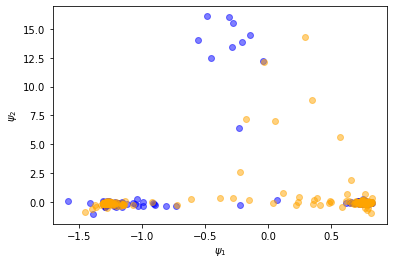

In [65]:
synth_traj_id = 0
fig, ax = plt.subplots()

if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeors(hde_coords[::lag_prop,0].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,0], hde_coords[::lag_prop,1], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], synth_trajs[synth_traj_id][:,1], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

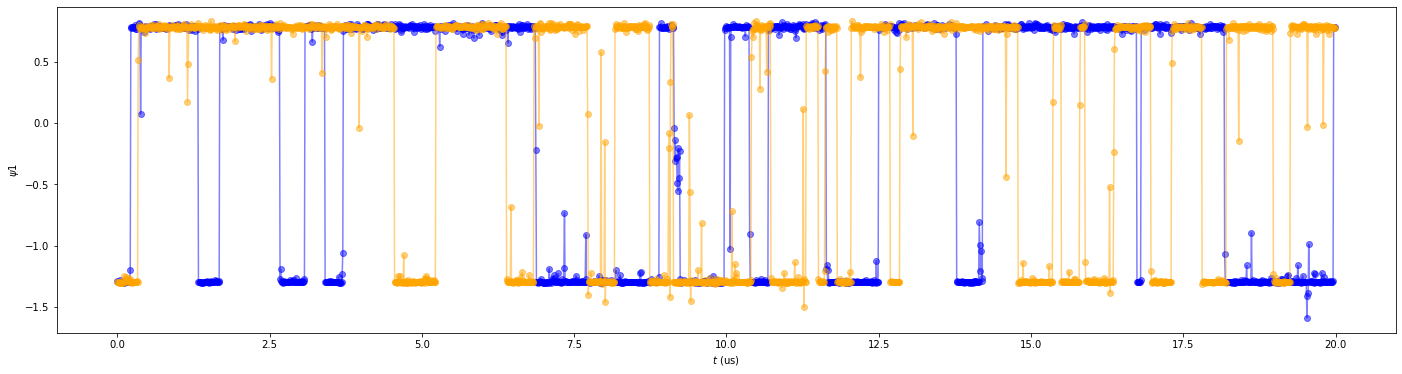

In [120]:
synth_traj_id = 1
psi_id = 0

fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], color='blue', alpha=0.5, marker='o')
ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$'+str(psi_id+1))
plt.show()

## (3) generator

#### x_train = scaled latent space coordinates

In [101]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [77]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [78]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 100000 frames, 10 atoms, 10 residues, and unitcells at 0x7ff037a3c0b8>

In [79]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

NGLWidget(count=2000)

In [80]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [81]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [82]:
y_train = xyz_scaler.fit_transform(xyz)

In [83]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [85]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               10600     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                6030      
Total params: 56,830
Trainable params: 56,830
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               6600      
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_

In [86]:
molgen.fit(x_train, y_train)

0 [D loss: 5.695393] [G loss: 0.023354]
1 [D loss: 5.170834] [G loss: 0.022245]
2 [D loss: 4.729492] [G loss: 0.020367]
3 [D loss: 4.327546] [G loss: 0.019371]
4 [D loss: 3.949142] [G loss: 0.016691]
5 [D loss: 3.586390] [G loss: 0.014424]
6 [D loss: 3.241128] [G loss: 0.010118]
7 [D loss: 2.911939] [G loss: 0.006544]
8 [D loss: 2.596016] [G loss: 0.000702]
9 [D loss: 2.293118] [G loss: -0.005114]
10 [D loss: 2.000067] [G loss: -0.011508]
11 [D loss: 1.729247] [G loss: -0.018371]
12 [D loss: 1.464812] [G loss: -0.027142]
13 [D loss: 1.223070] [G loss: -0.036910]
14 [D loss: 0.990562] [G loss: -0.043945]
15 [D loss: 0.771953] [G loss: -0.052582]
16 [D loss: 0.579962] [G loss: -0.065430]
17 [D loss: 0.398266] [G loss: -0.074397]
18 [D loss: 0.240523] [G loss: -0.084976]
19 [D loss: 0.092510] [G loss: -0.098175]
20 [D loss: -0.035362] [G loss: -0.111862]
21 [D loss: -0.143102] [G loss: -0.124260]
22 [D loss: -0.244094] [G loss: -0.138496]
23 [D loss: -0.320974] [G loss: -0.150263]
24 [D l

190 [D loss: -0.526330] [G loss: -0.265316]
191 [D loss: -0.529850] [G loss: -0.247926]
192 [D loss: -0.523191] [G loss: -0.244671]
193 [D loss: -0.520437] [G loss: -0.221813]
194 [D loss: -0.509031] [G loss: -0.232665]
195 [D loss: -0.507944] [G loss: -0.210984]
196 [D loss: -0.506046] [G loss: -0.216995]
197 [D loss: -0.500167] [G loss: -0.199848]
198 [D loss: -0.491360] [G loss: -0.200450]
199 [D loss: -0.489976] [G loss: -0.179102]
200 [D loss: -0.490913] [G loss: -0.181976]
201 [D loss: -0.484515] [G loss: -0.165639]
202 [D loss: -0.487265] [G loss: -0.158530]
203 [D loss: -0.476613] [G loss: -0.145220]
204 [D loss: -0.470325] [G loss: -0.150675]
205 [D loss: -0.470324] [G loss: -0.144450]
206 [D loss: -0.462224] [G loss: -0.120354]
207 [D loss: -0.466962] [G loss: -0.124352]
208 [D loss: -0.462178] [G loss: -0.111372]
209 [D loss: -0.457110] [G loss: -0.087478]
210 [D loss: -0.461751] [G loss: -0.087728]
211 [D loss: -0.455753] [G loss: -0.072291]
212 [D loss: -0.450355] [G loss:

380 [D loss: -0.478753] [G loss: 0.370963]
381 [D loss: -0.474035] [G loss: 0.405314]
382 [D loss: -0.467206] [G loss: 0.342945]
383 [D loss: -0.462527] [G loss: 0.384103]
384 [D loss: -0.463332] [G loss: 0.342032]
385 [D loss: -0.472274] [G loss: 0.400839]
386 [D loss: -0.470056] [G loss: 0.346271]
387 [D loss: -0.459324] [G loss: 0.386321]
388 [D loss: -0.455776] [G loss: 0.305144]
389 [D loss: -0.455968] [G loss: 0.353486]
390 [D loss: -0.457544] [G loss: 0.316741]
391 [D loss: -0.460228] [G loss: 0.363039]
392 [D loss: -0.456290] [G loss: 0.290388]
393 [D loss: -0.456193] [G loss: 0.348837]
394 [D loss: -0.461774] [G loss: 0.301317]
395 [D loss: -0.454781] [G loss: 0.340078]
396 [D loss: -0.449713] [G loss: 0.281604]
397 [D loss: -0.455523] [G loss: 0.322299]
398 [D loss: -0.448082] [G loss: 0.256764]
399 [D loss: -0.447583] [G loss: 0.291792]
400 [D loss: -0.446950] [G loss: 0.255157]
401 [D loss: -0.443434] [G loss: 0.310659]
402 [D loss: -0.445992] [G loss: 0.269226]
403 [D loss

571 [D loss: -0.407130] [G loss: 0.151759]
572 [D loss: -0.415950] [G loss: 0.210460]
573 [D loss: -0.415194] [G loss: 0.152436]
574 [D loss: -0.412795] [G loss: 0.199846]
575 [D loss: -0.417736] [G loss: 0.179382]
576 [D loss: -0.413128] [G loss: 0.222350]
577 [D loss: -0.411440] [G loss: 0.169310]
578 [D loss: -0.415754] [G loss: 0.203446]
579 [D loss: -0.413208] [G loss: 0.155127]
580 [D loss: -0.411772] [G loss: 0.205073]
581 [D loss: -0.413724] [G loss: 0.157912]
582 [D loss: -0.417344] [G loss: 0.221988]
583 [D loss: -0.418546] [G loss: 0.164427]
584 [D loss: -0.413222] [G loss: 0.216542]
585 [D loss: -0.412470] [G loss: 0.156343]
586 [D loss: -0.417602] [G loss: 0.231167]
587 [D loss: -0.420412] [G loss: 0.165686]
588 [D loss: -0.419137] [G loss: 0.198348]
589 [D loss: -0.412022] [G loss: 0.146513]
590 [D loss: -0.415658] [G loss: 0.222607]
591 [D loss: -0.414662] [G loss: 0.168203]
592 [D loss: -0.414161] [G loss: 0.235614]
593 [D loss: -0.414063] [G loss: 0.165497]
594 [D loss

762 [D loss: -0.414660] [G loss: 0.250319]
763 [D loss: -0.410135] [G loss: 0.198186]
764 [D loss: -0.408298] [G loss: 0.258083]
765 [D loss: -0.412488] [G loss: 0.202317]
766 [D loss: -0.414915] [G loss: 0.266102]
767 [D loss: -0.414759] [G loss: 0.220886]
768 [D loss: -0.411869] [G loss: 0.255306]
769 [D loss: -0.410372] [G loss: 0.201369]
770 [D loss: -0.409011] [G loss: 0.259536]
771 [D loss: -0.414642] [G loss: 0.210968]
772 [D loss: -0.409973] [G loss: 0.272385]
773 [D loss: -0.414490] [G loss: 0.216842]
774 [D loss: -0.407514] [G loss: 0.258651]
775 [D loss: -0.410266] [G loss: 0.198029]
776 [D loss: -0.418866] [G loss: 0.266082]
777 [D loss: -0.408572] [G loss: 0.208736]
778 [D loss: -0.411162] [G loss: 0.269269]
779 [D loss: -0.411372] [G loss: 0.213725]
780 [D loss: -0.404816] [G loss: 0.266816]
781 [D loss: -0.412625] [G loss: 0.218960]
782 [D loss: -0.409909] [G loss: 0.279801]
783 [D loss: -0.416653] [G loss: 0.221405]
784 [D loss: -0.413929] [G loss: 0.273755]
785 [D loss

953 [D loss: -0.388120] [G loss: 0.244170]
954 [D loss: -0.393759] [G loss: 0.195587]
955 [D loss: -0.394732] [G loss: 0.267333]
956 [D loss: -0.392981] [G loss: 0.196060]
957 [D loss: -0.394834] [G loss: 0.241562]
958 [D loss: -0.390398] [G loss: 0.175058]
959 [D loss: -0.397666] [G loss: 0.243118]
960 [D loss: -0.388173] [G loss: 0.205053]
961 [D loss: -0.387366] [G loss: 0.270556]
962 [D loss: -0.387348] [G loss: 0.191326]
963 [D loss: -0.397514] [G loss: 0.261521]
964 [D loss: -0.391967] [G loss: 0.194453]
965 [D loss: -0.388759] [G loss: 0.234944]
966 [D loss: -0.391018] [G loss: 0.183874]
967 [D loss: -0.389113] [G loss: 0.230591]
968 [D loss: -0.387442] [G loss: 0.181290]
969 [D loss: -0.389864] [G loss: 0.244431]
970 [D loss: -0.392223] [G loss: 0.195470]
971 [D loss: -0.392561] [G loss: 0.255356]
972 [D loss: -0.390627] [G loss: 0.184189]
973 [D loss: -0.386085] [G loss: 0.240292]
974 [D loss: -0.389157] [G loss: 0.192882]
975 [D loss: -0.390537] [G loss: 0.246258]
976 [D loss

1141 [D loss: -0.345438] [G loss: 0.056477]
1142 [D loss: -0.344311] [G loss: -0.009314]
1143 [D loss: -0.338029] [G loss: 0.053079]
1144 [D loss: -0.344262] [G loss: -0.004169]
1145 [D loss: -0.342495] [G loss: 0.043702]
1146 [D loss: -0.346098] [G loss: -0.014438]
1147 [D loss: -0.339064] [G loss: 0.031403]
1148 [D loss: -0.337536] [G loss: -0.025679]
1149 [D loss: -0.337559] [G loss: 0.029177]
1150 [D loss: -0.338819] [G loss: -0.026536]
1151 [D loss: -0.336976] [G loss: 0.029706]
1152 [D loss: -0.336242] [G loss: -0.033266]
1153 [D loss: -0.340295] [G loss: 0.026200]
1154 [D loss: -0.336761] [G loss: -0.032176]
1155 [D loss: -0.342298] [G loss: 0.042531]
1156 [D loss: -0.329241] [G loss: -0.046981]
1157 [D loss: -0.337862] [G loss: 0.008830]
1158 [D loss: -0.336716] [G loss: -0.054615]
1159 [D loss: -0.342944] [G loss: 0.004674]
1160 [D loss: -0.319430] [G loss: -0.067154]
1161 [D loss: -0.330592] [G loss: -0.003622]
1162 [D loss: -0.333711] [G loss: -0.063266]
1163 [D loss: -0.331

1324 [D loss: -0.206692] [G loss: -1.000868]
1325 [D loss: -0.203121] [G loss: -0.967817]
1326 [D loss: -0.202217] [G loss: -0.981920]
1327 [D loss: -0.203633] [G loss: -0.947310]
1328 [D loss: -0.203851] [G loss: -1.010848]
1329 [D loss: -0.205653] [G loss: -0.975020]
1330 [D loss: -0.202414] [G loss: -0.994625]
1331 [D loss: -0.200910] [G loss: -0.959407]
1332 [D loss: -0.199181] [G loss: -1.038700]
1333 [D loss: -0.204565] [G loss: -0.999390]
1334 [D loss: -0.199672] [G loss: -1.027877]
1335 [D loss: -0.206684] [G loss: -0.985534]
1336 [D loss: -0.200028] [G loss: -1.036134]
1337 [D loss: -0.201827] [G loss: -1.005738]
1338 [D loss: -0.202052] [G loss: -1.044193]
1339 [D loss: -0.202101] [G loss: -1.012508]
1340 [D loss: -0.203577] [G loss: -1.032655]
1341 [D loss: -0.201941] [G loss: -1.017579]
1342 [D loss: -0.204391] [G loss: -1.051754]
1343 [D loss: -0.198692] [G loss: -1.039844]
1344 [D loss: -0.201753] [G loss: -1.051205]
1345 [D loss: -0.202277] [G loss: -1.026490]
1346 [D lo

1507 [D loss: -0.216381] [G loss: -1.002319]
1508 [D loss: -0.216255] [G loss: -1.039306]
1509 [D loss: -0.215788] [G loss: -1.031310]
1510 [D loss: -0.218659] [G loss: -1.037158]
1511 [D loss: -0.213753] [G loss: -1.003479]
1512 [D loss: -0.217301] [G loss: -1.028915]
1513 [D loss: -0.216460] [G loss: -1.020460]
1514 [D loss: -0.215680] [G loss: -1.024353]
1515 [D loss: -0.216087] [G loss: -1.018969]
1516 [D loss: -0.214760] [G loss: -1.028073]
1517 [D loss: -0.213528] [G loss: -1.006302]
1518 [D loss: -0.217761] [G loss: -1.021500]
1519 [D loss: -0.215577] [G loss: -1.002625]
1520 [D loss: -0.217551] [G loss: -1.033875]
1521 [D loss: -0.218168] [G loss: -1.009994]
1522 [D loss: -0.211878] [G loss: -1.024032]
1523 [D loss: -0.217144] [G loss: -1.006102]
1524 [D loss: -0.215068] [G loss: -1.018493]
1525 [D loss: -0.215261] [G loss: -1.018368]
1526 [D loss: -0.215331] [G loss: -1.039506]
1527 [D loss: -0.212227] [G loss: -0.998233]
1528 [D loss: -0.213751] [G loss: -0.998352]
1529 [D lo

1690 [D loss: -0.184613] [G loss: -1.084763]
1691 [D loss: -0.189956] [G loss: -1.046341]
1692 [D loss: -0.186864] [G loss: -1.079712]
1693 [D loss: -0.184508] [G loss: -1.060422]
1694 [D loss: -0.184131] [G loss: -1.082577]
1695 [D loss: -0.181542] [G loss: -1.053512]
1696 [D loss: -0.183916] [G loss: -1.072510]
1697 [D loss: -0.185126] [G loss: -1.059583]
1698 [D loss: -0.183667] [G loss: -1.075086]
1699 [D loss: -0.182550] [G loss: -1.069522]
1700 [D loss: -0.181953] [G loss: -1.072464]
1701 [D loss: -0.182149] [G loss: -1.065659]
1702 [D loss: -0.179137] [G loss: -1.108334]
1703 [D loss: -0.182745] [G loss: -1.060856]
1704 [D loss: -0.177900] [G loss: -1.104740]
1705 [D loss: -0.179874] [G loss: -1.057491]
1706 [D loss: -0.181144] [G loss: -1.099380]
1707 [D loss: -0.181375] [G loss: -1.068127]
1708 [D loss: -0.181142] [G loss: -1.096925]
1709 [D loss: -0.182134] [G loss: -1.076785]
1710 [D loss: -0.178550] [G loss: -1.103226]
1711 [D loss: -0.182000] [G loss: -1.057919]
1712 [D lo

1873 [D loss: -0.128662] [G loss: -1.251462]
1874 [D loss: -0.129920] [G loss: -1.254519]
1875 [D loss: -0.130511] [G loss: -1.222524]
1876 [D loss: -0.130185] [G loss: -1.278157]
1877 [D loss: -0.130864] [G loss: -1.221489]
1878 [D loss: -0.129300] [G loss: -1.247070]
1879 [D loss: -0.131866] [G loss: -1.237254]
1880 [D loss: -0.129549] [G loss: -1.268054]
1881 [D loss: -0.128296] [G loss: -1.231496]
1882 [D loss: -0.127364] [G loss: -1.251109]
1883 [D loss: -0.128616] [G loss: -1.248607]
1884 [D loss: -0.129232] [G loss: -1.259115]
1885 [D loss: -0.128826] [G loss: -1.219971]
1886 [D loss: -0.126634] [G loss: -1.282114]
1887 [D loss: -0.125438] [G loss: -1.244332]
1888 [D loss: -0.126214] [G loss: -1.262084]
1889 [D loss: -0.126507] [G loss: -1.248832]
1890 [D loss: -0.127341] [G loss: -1.273355]
1891 [D loss: -0.125007] [G loss: -1.242055]
1892 [D loss: -0.124921] [G loss: -1.292958]
1893 [D loss: -0.124036] [G loss: -1.242191]
1894 [D loss: -0.122882] [G loss: -1.272572]
1895 [D lo

2056 [D loss: -0.092987] [G loss: -1.252616]
2057 [D loss: -0.092885] [G loss: -1.207042]
2058 [D loss: -0.091112] [G loss: -1.252441]
2059 [D loss: -0.092255] [G loss: -1.219616]
2060 [D loss: -0.089275] [G loss: -1.237437]
2061 [D loss: -0.092529] [G loss: -1.233086]
2062 [D loss: -0.091574] [G loss: -1.247925]
2063 [D loss: -0.093372] [G loss: -1.202933]
2064 [D loss: -0.090036] [G loss: -1.246297]
2065 [D loss: -0.092304] [G loss: -1.212602]
2066 [D loss: -0.091052] [G loss: -1.249999]
2067 [D loss: -0.090376] [G loss: -1.216241]
2068 [D loss: -0.089986] [G loss: -1.212023]
2069 [D loss: -0.091530] [G loss: -1.208144]
2070 [D loss: -0.090624] [G loss: -1.229611]
2071 [D loss: -0.090383] [G loss: -1.215168]
2072 [D loss: -0.089443] [G loss: -1.234622]
2073 [D loss: -0.091562] [G loss: -1.201053]
2074 [D loss: -0.090865] [G loss: -1.240031]
2075 [D loss: -0.089177] [G loss: -1.204912]
2076 [D loss: -0.089003] [G loss: -1.232435]
2077 [D loss: -0.088670] [G loss: -1.211047]
2078 [D lo

2239 [D loss: -0.069197] [G loss: -1.240408]
2240 [D loss: -0.067690] [G loss: -1.262586]
2241 [D loss: -0.068532] [G loss: -1.230712]
2242 [D loss: -0.067178] [G loss: -1.298707]
2243 [D loss: -0.068451] [G loss: -1.222823]
2244 [D loss: -0.068024] [G loss: -1.276245]
2245 [D loss: -0.069007] [G loss: -1.238051]
2246 [D loss: -0.067325] [G loss: -1.266978]
2247 [D loss: -0.066001] [G loss: -1.249076]
2248 [D loss: -0.067951] [G loss: -1.263537]
2249 [D loss: -0.066931] [G loss: -1.245605]
2250 [D loss: -0.067869] [G loss: -1.280313]
2251 [D loss: -0.067769] [G loss: -1.249024]
2252 [D loss: -0.066426] [G loss: -1.285388]
2253 [D loss: -0.067072] [G loss: -1.234861]
2254 [D loss: -0.065946] [G loss: -1.291433]
2255 [D loss: -0.065915] [G loss: -1.244870]
2256 [D loss: -0.064591] [G loss: -1.275959]
2257 [D loss: -0.066828] [G loss: -1.252401]
2258 [D loss: -0.067617] [G loss: -1.272541]
2259 [D loss: -0.065706] [G loss: -1.241574]
2260 [D loss: -0.066395] [G loss: -1.289024]
2261 [D lo

2422 [D loss: -0.050664] [G loss: -1.274243]
2423 [D loss: -0.050272] [G loss: -1.230113]
2424 [D loss: -0.049989] [G loss: -1.282725]
2425 [D loss: -0.049461] [G loss: -1.235217]
2426 [D loss: -0.050253] [G loss: -1.283499]
2427 [D loss: -0.051057] [G loss: -1.236979]
2428 [D loss: -0.048208] [G loss: -1.260620]
2429 [D loss: -0.049340] [G loss: -1.246420]
2430 [D loss: -0.048142] [G loss: -1.280383]
2431 [D loss: -0.050300] [G loss: -1.234850]
2432 [D loss: -0.048472] [G loss: -1.284559]
2433 [D loss: -0.048170] [G loss: -1.246093]
2434 [D loss: -0.048408] [G loss: -1.245982]
2435 [D loss: -0.048053] [G loss: -1.242716]
2436 [D loss: -0.048048] [G loss: -1.277883]
2437 [D loss: -0.049078] [G loss: -1.234698]
2438 [D loss: -0.048944] [G loss: -1.285717]
2439 [D loss: -0.050471] [G loss: -1.225230]
2440 [D loss: -0.048545] [G loss: -1.273682]
2441 [D loss: -0.047474] [G loss: -1.240370]
2442 [D loss: -0.049688] [G loss: -1.276991]
2443 [D loss: -0.048233] [G loss: -1.235106]
2444 [D lo

MolGen(activation='swish', batch_size=30000, hidden_layer_depth=2,
       hidden_size=200, latent_dim=2, n_discriminator=5, n_epochs=2500,
       noise_dim=50, output_dim=30, verbose=True)

In [87]:
molgen.fit(x_train, y_train)

0 [D loss: -0.044414] [G loss: -1.262821]
1 [D loss: -0.043956] [G loss: -1.220659]
2 [D loss: -0.045763] [G loss: -1.252606]
3 [D loss: -0.046646] [G loss: -1.193414]
4 [D loss: -0.043307] [G loss: -1.258219]
5 [D loss: -0.044686] [G loss: -1.215695]
6 [D loss: -0.043297] [G loss: -1.253367]
7 [D loss: -0.044377] [G loss: -1.211911]
8 [D loss: -0.044217] [G loss: -1.258666]
9 [D loss: -0.044947] [G loss: -1.205245]
10 [D loss: -0.043125] [G loss: -1.244560]
11 [D loss: -0.044925] [G loss: -1.203000]
12 [D loss: -0.043627] [G loss: -1.248700]
13 [D loss: -0.044560] [G loss: -1.212236]
14 [D loss: -0.042990] [G loss: -1.251996]
15 [D loss: -0.045792] [G loss: -1.215821]
16 [D loss: -0.043401] [G loss: -1.227608]
17 [D loss: -0.043627] [G loss: -1.213568]
18 [D loss: -0.043329] [G loss: -1.260539]
19 [D loss: -0.045102] [G loss: -1.210447]
20 [D loss: -0.043725] [G loss: -1.242474]
21 [D loss: -0.042462] [G loss: -1.209476]
22 [D loss: -0.043756] [G loss: -1.239421]
23 [D loss: -0.042978

189 [D loss: -0.038479] [G loss: -1.179035]
190 [D loss: -0.036427] [G loss: -1.218096]
191 [D loss: -0.039267] [G loss: -1.161635]
192 [D loss: -0.036573] [G loss: -1.212838]
193 [D loss: -0.037072] [G loss: -1.149156]
194 [D loss: -0.037559] [G loss: -1.233144]
195 [D loss: -0.038130] [G loss: -1.160780]
196 [D loss: -0.037246] [G loss: -1.230224]
197 [D loss: -0.036475] [G loss: -1.158491]
198 [D loss: -0.038473] [G loss: -1.209242]
199 [D loss: -0.037382] [G loss: -1.155398]
200 [D loss: -0.037607] [G loss: -1.219469]
201 [D loss: -0.039755] [G loss: -1.168324]
202 [D loss: -0.038055] [G loss: -1.202868]
203 [D loss: -0.037643] [G loss: -1.161729]
204 [D loss: -0.036012] [G loss: -1.206351]
205 [D loss: -0.037655] [G loss: -1.160401]
206 [D loss: -0.036048] [G loss: -1.222710]
207 [D loss: -0.036705] [G loss: -1.168210]
208 [D loss: -0.037370] [G loss: -1.224080]
209 [D loss: -0.038896] [G loss: -1.150803]
210 [D loss: -0.036437] [G loss: -1.215374]
211 [D loss: -0.037004] [G loss:

376 [D loss: -0.033705] [G loss: -1.201859]
377 [D loss: -0.034389] [G loss: -1.160224]
378 [D loss: -0.033497] [G loss: -1.191584]
379 [D loss: -0.033805] [G loss: -1.127985]
380 [D loss: -0.035117] [G loss: -1.221882]
381 [D loss: -0.034471] [G loss: -1.130934]
382 [D loss: -0.034887] [G loss: -1.203070]
383 [D loss: -0.033365] [G loss: -1.134752]
384 [D loss: -0.033958] [G loss: -1.204471]
385 [D loss: -0.035120] [G loss: -1.135912]
386 [D loss: -0.034183] [G loss: -1.203624]
387 [D loss: -0.033872] [G loss: -1.133071]
388 [D loss: -0.033413] [G loss: -1.217085]
389 [D loss: -0.034935] [G loss: -1.130016]
390 [D loss: -0.034535] [G loss: -1.192679]
391 [D loss: -0.032866] [G loss: -1.144975]
392 [D loss: -0.033923] [G loss: -1.201916]
393 [D loss: -0.034160] [G loss: -1.145097]
394 [D loss: -0.031814] [G loss: -1.171874]
395 [D loss: -0.034939] [G loss: -1.152053]
396 [D loss: -0.034095] [G loss: -1.209852]
397 [D loss: -0.034350] [G loss: -1.153331]
398 [D loss: -0.033810] [G loss:

563 [D loss: -0.033995] [G loss: -1.161363]
564 [D loss: -0.032744] [G loss: -1.220259]
565 [D loss: -0.033981] [G loss: -1.148204]
566 [D loss: -0.032563] [G loss: -1.215166]
567 [D loss: -0.033200] [G loss: -1.168338]
568 [D loss: -0.034226] [G loss: -1.225749]
569 [D loss: -0.033796] [G loss: -1.163441]
570 [D loss: -0.033431] [G loss: -1.228259]
571 [D loss: -0.033275] [G loss: -1.154587]
572 [D loss: -0.033430] [G loss: -1.221557]
573 [D loss: -0.032612] [G loss: -1.168012]
574 [D loss: -0.031465] [G loss: -1.211504]
575 [D loss: -0.033969] [G loss: -1.164119]
576 [D loss: -0.032045] [G loss: -1.199505]
577 [D loss: -0.033024] [G loss: -1.175491]
578 [D loss: -0.033349] [G loss: -1.200613]
579 [D loss: -0.033786] [G loss: -1.179576]
580 [D loss: -0.033579] [G loss: -1.218639]
581 [D loss: -0.033099] [G loss: -1.161578]
582 [D loss: -0.032033] [G loss: -1.233873]
583 [D loss: -0.033395] [G loss: -1.147282]
584 [D loss: -0.032156] [G loss: -1.243533]
585 [D loss: -0.032571] [G loss:

750 [D loss: -0.031713] [G loss: -1.196910]
751 [D loss: -0.031698] [G loss: -1.143979]
752 [D loss: -0.031908] [G loss: -1.205853]
753 [D loss: -0.032328] [G loss: -1.159369]
754 [D loss: -0.031319] [G loss: -1.200561]
755 [D loss: -0.031672] [G loss: -1.142468]
756 [D loss: -0.032260] [G loss: -1.200086]
757 [D loss: -0.031349] [G loss: -1.143255]
758 [D loss: -0.030955] [G loss: -1.192208]
759 [D loss: -0.032250] [G loss: -1.149978]
760 [D loss: -0.032387] [G loss: -1.191908]
761 [D loss: -0.031364] [G loss: -1.145461]
762 [D loss: -0.031350] [G loss: -1.192317]
763 [D loss: -0.032580] [G loss: -1.135013]
764 [D loss: -0.030024] [G loss: -1.209364]
765 [D loss: -0.032988] [G loss: -1.149400]
766 [D loss: -0.030821] [G loss: -1.209354]
767 [D loss: -0.032813] [G loss: -1.140062]
768 [D loss: -0.029539] [G loss: -1.203668]
769 [D loss: -0.032570] [G loss: -1.130359]
770 [D loss: -0.031326] [G loss: -1.193234]
771 [D loss: -0.031314] [G loss: -1.146420]
772 [D loss: -0.031759] [G loss:

937 [D loss: -0.030497] [G loss: -1.112492]
938 [D loss: -0.028900] [G loss: -1.155705]
939 [D loss: -0.029771] [G loss: -1.101563]
940 [D loss: -0.028545] [G loss: -1.152035]
941 [D loss: -0.030216] [G loss: -1.087708]
942 [D loss: -0.028962] [G loss: -1.184616]
943 [D loss: -0.030062] [G loss: -1.071244]
944 [D loss: -0.029896] [G loss: -1.164131]
945 [D loss: -0.030777] [G loss: -1.095765]
946 [D loss: -0.029633] [G loss: -1.142290]
947 [D loss: -0.029812] [G loss: -1.105346]
948 [D loss: -0.029471] [G loss: -1.145508]
949 [D loss: -0.030487] [G loss: -1.099609]
950 [D loss: -0.029127] [G loss: -1.146772]
951 [D loss: -0.029812] [G loss: -1.122115]
952 [D loss: -0.029321] [G loss: -1.165083]
953 [D loss: -0.030064] [G loss: -1.091113]
954 [D loss: -0.027217] [G loss: -1.147040]
955 [D loss: -0.029118] [G loss: -1.096298]
956 [D loss: -0.029819] [G loss: -1.141113]
957 [D loss: -0.028574] [G loss: -1.097169]
958 [D loss: -0.029432] [G loss: -1.178509]
959 [D loss: -0.029891] [G loss:

1121 [D loss: -0.028997] [G loss: -1.075855]
1122 [D loss: -0.027062] [G loss: -1.091733]
1123 [D loss: -0.028684] [G loss: -1.080371]
1124 [D loss: -0.026640] [G loss: -1.083054]
1125 [D loss: -0.027004] [G loss: -1.069288]
1126 [D loss: -0.027664] [G loss: -1.107956]
1127 [D loss: -0.028536] [G loss: -1.061630]
1128 [D loss: -0.027632] [G loss: -1.114883]
1129 [D loss: -0.026784] [G loss: -1.078628]
1130 [D loss: -0.026620] [G loss: -1.107178]
1131 [D loss: -0.028668] [G loss: -1.030444]
1132 [D loss: -0.028141] [G loss: -1.137618]
1133 [D loss: -0.026321] [G loss: -1.040967]
1134 [D loss: -0.028229] [G loss: -1.128219]
1135 [D loss: -0.028263] [G loss: -1.037049]
1136 [D loss: -0.028342] [G loss: -1.102372]
1137 [D loss: -0.026952] [G loss: -1.058337]
1138 [D loss: -0.026473] [G loss: -1.087643]
1139 [D loss: -0.027881] [G loss: -1.071407]
1140 [D loss: -0.027167] [G loss: -1.095273]
1141 [D loss: -0.028285] [G loss: -1.070874]
1142 [D loss: -0.027519] [G loss: -1.101195]
1143 [D lo

1304 [D loss: -0.025552] [G loss: -1.046878]
1305 [D loss: -0.026069] [G loss: -1.023866]
1306 [D loss: -0.026601] [G loss: -1.045212]
1307 [D loss: -0.025972] [G loss: -1.019469]
1308 [D loss: -0.026129] [G loss: -1.055848]
1309 [D loss: -0.025643] [G loss: -1.010392]
1310 [D loss: -0.026374] [G loss: -1.053037]
1311 [D loss: -0.026161] [G loss: -1.009630]
1312 [D loss: -0.026238] [G loss: -1.058823]
1313 [D loss: -0.025939] [G loss: -1.009889]
1314 [D loss: -0.025920] [G loss: -1.080521]
1315 [D loss: -0.024908] [G loss: -1.004195]
1316 [D loss: -0.026422] [G loss: -1.075455]
1317 [D loss: -0.026766] [G loss: -0.986101]
1318 [D loss: -0.025331] [G loss: -1.063778]
1319 [D loss: -0.026508] [G loss: -1.005053]
1320 [D loss: -0.027182] [G loss: -1.062760]
1321 [D loss: -0.026017] [G loss: -0.986512]
1322 [D loss: -0.026821] [G loss: -1.061756]
1323 [D loss: -0.026328] [G loss: -1.001208]
1324 [D loss: -0.026614] [G loss: -1.058408]
1325 [D loss: -0.025037] [G loss: -1.024045]
1326 [D lo

1487 [D loss: -0.023546] [G loss: -0.975816]
1488 [D loss: -0.023532] [G loss: -1.043949]
1489 [D loss: -0.023761] [G loss: -0.984697]
1490 [D loss: -0.023481] [G loss: -1.004777]
1491 [D loss: -0.023950] [G loss: -0.971252]
1492 [D loss: -0.022894] [G loss: -1.030514]
1493 [D loss: -0.024581] [G loss: -0.983097]
1494 [D loss: -0.024208] [G loss: -1.016965]
1495 [D loss: -0.024512] [G loss: -0.998902]
1496 [D loss: -0.022336] [G loss: -1.010067]
1497 [D loss: -0.024610] [G loss: -0.981996]
1498 [D loss: -0.022814] [G loss: -1.020370]
1499 [D loss: -0.022550] [G loss: -0.988224]
1500 [D loss: -0.023412] [G loss: -1.024003]
1501 [D loss: -0.023281] [G loss: -0.982667]
1502 [D loss: -0.023298] [G loss: -1.014784]
1503 [D loss: -0.022933] [G loss: -0.958117]
1504 [D loss: -0.022435] [G loss: -1.029236]
1505 [D loss: -0.025046] [G loss: -0.981937]
1506 [D loss: -0.024456] [G loss: -1.029129]
1507 [D loss: -0.022900] [G loss: -0.974733]
1508 [D loss: -0.024268] [G loss: -1.013656]
1509 [D lo

1670 [D loss: -0.021326] [G loss: -0.997005]
1671 [D loss: -0.022860] [G loss: -0.978576]
1672 [D loss: -0.022472] [G loss: -0.988339]
1673 [D loss: -0.022224] [G loss: -0.972164]
1674 [D loss: -0.021178] [G loss: -1.024414]
1675 [D loss: -0.022585] [G loss: -0.980970]
1676 [D loss: -0.022675] [G loss: -0.977359]
1677 [D loss: -0.022594] [G loss: -0.985042]
1678 [D loss: -0.024471] [G loss: -1.011780]
1679 [D loss: -0.021670] [G loss: -0.957881]
1680 [D loss: -0.021676] [G loss: -1.034226]
1681 [D loss: -0.022219] [G loss: -0.949281]
1682 [D loss: -0.021118] [G loss: -1.002821]
1683 [D loss: -0.023602] [G loss: -0.967284]
1684 [D loss: -0.022395] [G loss: -1.007463]
1685 [D loss: -0.021704] [G loss: -0.974413]
1686 [D loss: -0.022701] [G loss: -0.990539]
1687 [D loss: -0.022149] [G loss: -0.977096]
1688 [D loss: -0.021937] [G loss: -1.000672]
1689 [D loss: -0.021754] [G loss: -0.971663]
1690 [D loss: -0.021387] [G loss: -1.013432]
1691 [D loss: -0.022665] [G loss: -0.979967]
1692 [D lo

1853 [D loss: -0.019839] [G loss: -0.947008]
1854 [D loss: -0.020735] [G loss: -1.008481]
1855 [D loss: -0.020040] [G loss: -0.947188]
1856 [D loss: -0.022637] [G loss: -0.998828]
1857 [D loss: -0.020370] [G loss: -0.967345]
1858 [D loss: -0.019233] [G loss: -0.995682]
1859 [D loss: -0.020492] [G loss: -0.980055]
1860 [D loss: -0.021097] [G loss: -1.013976]
1861 [D loss: -0.019988] [G loss: -0.940508]
1862 [D loss: -0.019739] [G loss: -1.001891]
1863 [D loss: -0.020681] [G loss: -0.964677]
1864 [D loss: -0.020526] [G loss: -1.014941]
1865 [D loss: -0.020857] [G loss: -0.964460]
1866 [D loss: -0.020789] [G loss: -1.000016]
1867 [D loss: -0.021011] [G loss: -0.974595]
1868 [D loss: -0.021214] [G loss: -0.975512]
1869 [D loss: -0.019452] [G loss: -0.978072]
1870 [D loss: -0.020640] [G loss: -0.981014]
1871 [D loss: -0.019050] [G loss: -0.964402]
1872 [D loss: -0.019940] [G loss: -0.994877]
1873 [D loss: -0.020665] [G loss: -0.946045]
1874 [D loss: -0.020738] [G loss: -0.996212]
1875 [D lo

2036 [D loss: -0.018635] [G loss: -0.981859]
2037 [D loss: -0.018769] [G loss: -0.963075]
2038 [D loss: -0.017399] [G loss: -0.964308]
2039 [D loss: -0.019799] [G loss: -0.957353]
2040 [D loss: -0.018815] [G loss: -0.969295]
2041 [D loss: -0.018270] [G loss: -0.933881]
2042 [D loss: -0.018704] [G loss: -0.981706]
2043 [D loss: -0.020320] [G loss: -0.954848]
2044 [D loss: -0.018191] [G loss: -0.953975]
2045 [D loss: -0.018718] [G loss: -0.950788]
2046 [D loss: -0.018568] [G loss: -0.982418]
2047 [D loss: -0.018901] [G loss: -0.930664]
2048 [D loss: -0.017307] [G loss: -0.975420]
2049 [D loss: -0.017936] [G loss: -0.942976]
2050 [D loss: -0.018474] [G loss: -0.958554]
2051 [D loss: -0.018219] [G loss: -0.939195]
2052 [D loss: -0.018016] [G loss: -0.986620]
2053 [D loss: -0.018163] [G loss: -0.948918]
2054 [D loss: -0.018736] [G loss: -0.946288]
2055 [D loss: -0.018843] [G loss: -0.958744]
2056 [D loss: -0.018900] [G loss: -0.964843]
2057 [D loss: -0.017751] [G loss: -0.944472]
2058 [D lo

2219 [D loss: -0.017666] [G loss: -0.891949]
2220 [D loss: -0.017971] [G loss: -0.930424]
2221 [D loss: -0.017182] [G loss: -0.907212]
2222 [D loss: -0.017239] [G loss: -0.926083]
2223 [D loss: -0.017874] [G loss: -0.899292]
2224 [D loss: -0.017757] [G loss: -0.940248]
2225 [D loss: -0.018672] [G loss: -0.916133]
2226 [D loss: -0.019181] [G loss: -0.912153]
2227 [D loss: -0.017530] [G loss: -0.931684]
2228 [D loss: -0.017727] [G loss: -0.905073]
2229 [D loss: -0.017533] [G loss: -0.925908]
2230 [D loss: -0.018639] [G loss: -0.934402]
2231 [D loss: -0.017607] [G loss: -0.902815]
2232 [D loss: -0.018282] [G loss: -0.923343]
2233 [D loss: -0.017866] [G loss: -0.913147]
2234 [D loss: -0.017522] [G loss: -0.956482]
2235 [D loss: -0.018013] [G loss: -0.895770]
2236 [D loss: -0.017488] [G loss: -0.938764]
2237 [D loss: -0.017869] [G loss: -0.903443]
2238 [D loss: -0.018904] [G loss: -0.935913]
2239 [D loss: -0.017820] [G loss: -0.907895]
2240 [D loss: -0.019181] [G loss: -0.912048]
2241 [D lo

2402 [D loss: -0.018008] [G loss: -0.903747]
2403 [D loss: -0.016261] [G loss: -0.877686]
2404 [D loss: -0.017148] [G loss: -0.880066]
2405 [D loss: -0.017171] [G loss: -0.882525]
2406 [D loss: -0.016126] [G loss: -0.873231]
2407 [D loss: -0.017417] [G loss: -0.880367]
2408 [D loss: -0.017522] [G loss: -0.924727]
2409 [D loss: -0.018088] [G loss: -0.868210]
2410 [D loss: -0.016149] [G loss: -0.894330]
2411 [D loss: -0.018331] [G loss: -0.887104]
2412 [D loss: -0.018571] [G loss: -0.867721]
2413 [D loss: -0.017394] [G loss: -0.901166]
2414 [D loss: -0.017323] [G loss: -0.887753]
2415 [D loss: -0.016878] [G loss: -0.894833]
2416 [D loss: -0.016946] [G loss: -0.860737]
2417 [D loss: -0.017403] [G loss: -0.907302]
2418 [D loss: -0.017119] [G loss: -0.892452]
2419 [D loss: -0.018841] [G loss: -0.888427]
2420 [D loss: -0.017668] [G loss: -0.884076]
2421 [D loss: -0.017636] [G loss: -0.879760]
2422 [D loss: -0.017926] [G loss: -0.911118]
2423 [D loss: -0.018018] [G loss: -0.873661]
2424 [D lo

MolGen(activation='swish', batch_size=30000, hidden_layer_depth=2,
       hidden_size=200, latent_dim=2, n_discriminator=5, n_epochs=2500,
       noise_dim=50, output_dim=30, verbose=True)

In [90]:
molgen.generator.save('molgen_generator.h5')

In [91]:
molgen.discriminator.save('molgen_discriminator.h5')

#### decoding synthetic propagator trajectories

In [92]:
assert molgen.is_fitted == True

In [93]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [94]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [95]:
traj_ca[0].save_pdb('synth.pdb')

In [96]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [97]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [98]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

<mdtraj.Trajectory with 2000 frames, 10 atoms, 10 residues, without unitcells at 0x7ff0368b8630>

In [99]:
view = nv.show_mdtraj(traj_synth_obj)
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

NGLWidget(count=2000)

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [563]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [564]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [565]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

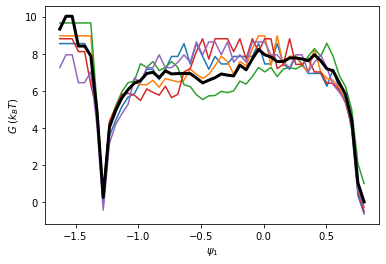

In [566]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

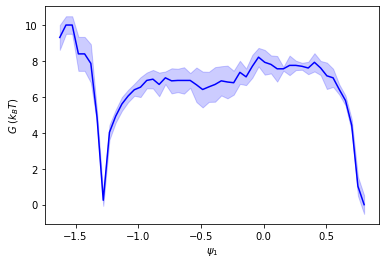

In [567]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [568]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [569]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [570]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

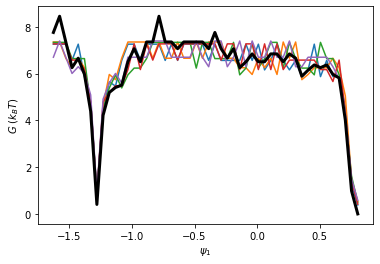

In [571]:
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, pmf_LSS, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

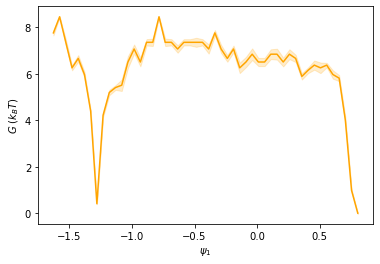

In [572]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

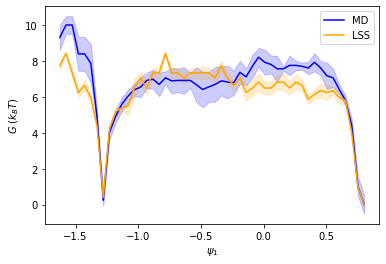

In [574]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

### kinetic (relaxation times)

In [302]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [303]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

In [304]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [305]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

MD relaxation times (ns) = 
441.372467 +/- 105.153030
154.753830 +/- 23.282644


In [306]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

In [575]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

/home/alf/anaconda3/envs/lss/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [576]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_synth[0,i], relax_synth_stderr[i]))

LSS relaxation times (ns) = 
232.088837 +/- 23.177208
4.624391 +/- nan


### structure (RMSD)